# Analysis of confout.pdb files

This is to check progress of the string simulations in a "not CV" space. IE we can look at gate COM, salt bridge progress, sugar coordination etc. 

The purpose of this is to check integrity of the simulations. Ideally we will compare 2 - 4 confout files at a time. This way you can see if there is some average drift or instabilities happening potentially

#### input:
Use simulations parsed by `per_iteration_confout.sh` (or `lazy_confout.sh`) which will take the `.gro` files from the `md/(#iteration)/restrained/confout.gro` and save only the protein (or wholesys). Then concatenate each bead output from this to have one continuous 'trajectory' which is # beads long

### Table of contents:
[**Gate distances**](#gate_dist)
- [Per condition](#gate_solo)
- [Comparing conditions](#gate_group)

[**Salt bridges**](#salt_br)

[**Contacts from Darko**](#Darko)

[**TM7b breakage**](#TM7b)

[**RMSD to original models**](#RMSD)

[**Hydration along Z axis**](#hydration)

[**Demystifying residues distance**](#demyst)

In [1]:
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
from gate_functions import *
import subprocess
from math import ceil
from MDAnalysis.analysis import density


In [2]:
indir = '../confout_files/measure_per_iteration'

In [23]:
wholesys = False
skip = 50

#conditions_max_iter = {'influx_BFRU_gate_CV':552, 'influx_apo_gate_CV':745}
#conditions_max_iter = {'efflux_BFRU_gate_CV':553, 'influx_BFRU_gate_CV':552}
#conditions_max_iter = {'influx_apo_gate_CV':745, 'efflux_BFRU_start':450}
#conditions_max_iter = {'efflux_BFRU_gate_CV':553, 'efflux_BFRU_start':450}

conditions_max_iter = {'influx_BFRU_gate_CV':552, 'influx_apo_gate_CV':745, 'efflux_BFRU_gate_CV':553, 'efflux_BFRU_start':450}

conditions_iterations = {}


for condition, max_iter in conditions_max_iter.items():
    iter_list = []
    for iteration in range(0, max_iter, skip):
        if iteration == 0:
            iter_list.append(1)
        else:
            iter_list.append(iteration)
    iter_list.append(max_iter)
    
    
    
    conditions_iterations[condition] = iter_list

In [24]:
conditions_universes = {}

for condition, iteration_list in conditions_iterations.items():
    universe_list = []
    for iteration in iteration_list:
        universe_list.append(mda.Universe(f'{indir}/{condition}.{iteration}.string.pdb'))
        #print(f'loading {condition}.{iteration}.string.pdb')
    
    conditions_universes[condition] = universe_list
    
n_beads = 16 - 1

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/topology/base.py:203: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  residx = np.zeros_like(criteria[0], dtype=np.int)


<h1><center>Gate distance</h1></center>



<a id='gate_dist'></a>

Here you customize how you want to plot this. You can compare different conditions at one iteration time, or plot some iterations per condition

First, create the dictionary of gate distances for each iteration per object

In [5]:
conditions_gates = {}

for condition, universe_list in conditions_universes.items():
    EC_list = []
    IC_list = []

    for simulation in universe_list:
        EC, IC = make_gate_arr(simulation, gate_EC = [(30,37), (289,295)], gate_IC = [(136,145), (386,394)])
        EC_list.append(EC)
        IC_list.append(IC)
    EC_list = np.array(EC_list)
    IC_list = np.array(IC_list)
    conditions_gates[condition] = [EC_list, IC_list]

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/core/selection.py:690: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(vals), dtype=np.bool)


returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists


Also make this GLUT5 atomisitic plot

In [6]:
def plot_G5_atomistic(ax, show_ends):
    # get all pieces together, then colors and naming consistent in plots
    G5_Out = np.array(['GLUT5_out', 'Out Open', 'green', "Greens"])
    G5_OutOcc = np.array(['GLUT5_out_occ', 'Out Occ.', 'grey', "Greys"])
    G5_Occ = np.array(['GLUT5_occ', 'Occluded', 'red', "Reds"])
    G5_InOcc = np.array(['GLUT5_in_occ', 'In Occ.', 'orange', "Oranges"])
    G5_In = np.array(['GLUT5_in', 'In Open', 'blue', "Blues"])
    all_sims = np.array([G5_Out, G5_OutOcc, G5_Occ, G5_InOcc, G5_In])


    f = plt.figure(figsize = (8,8))
    EC_atomistic = []
    IC_atomistic = []
    for n, sim in enumerate(all_sims):
        name = sim[0]
        ec = np.loadtxt('../../../GLUT5_atomistic/analysis/gate_dists/extracellular/%s.EC.xvg' %name)[:,1]
        ic = np.loadtxt('../../../GLUT5_atomistic/analysis/gate_dists/intracellular/%s.IC.xvg' %name)[:,1]
        EC_atomistic.append(ec)
        IC_atomistic.append(ic)

        ax.scatter(ic,ec, s = 4, alpha = 0.2, color = sim[2], label = sim[0])
        if show_ends:
            ax.scatter(ic[[0,-1]], ec[[0,-1]], s = [100,80], color = sim[2], edgecolors=['black','grey'],label = sim[0])

## For one condition, choosing iterations
<a id='gate_solo'></a>
If you want all iterations, make `iter_list = slice(0,None)`

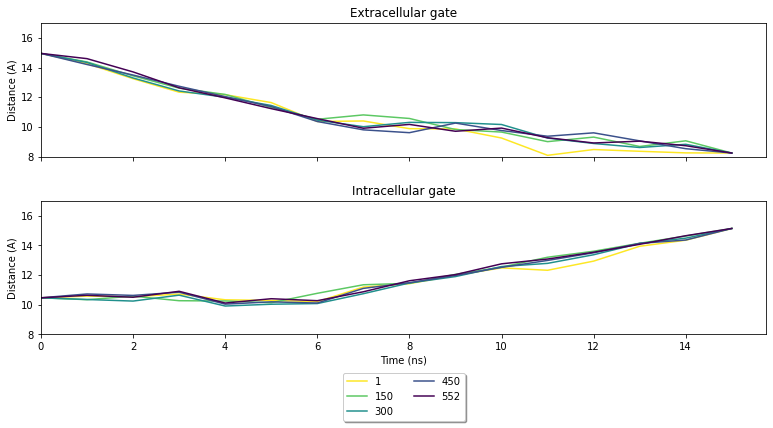

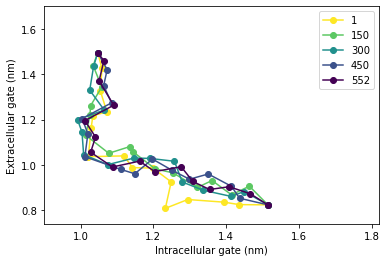

In [7]:
condition = 'influx_BFRU_gate_CV'
#iter_index = [0,3,9]
iter_index = slice(0,None,3) 
label_list = np.array([str(x) for x in conditions_iterations[condition]])[iter_index] 

colormap_colors = 'viridis_r'
cmap_vals = plt.cm.get_cmap(colormap_colors)
color_vals = cmap_vals(np.linspace(0,1,len(label_list)))


EC = conditions_gates[condition][0][iter_index]
IC = conditions_gates[condition][1][iter_index]



gate_dist_over_time(EC_list = EC , 
                   IC_list = IC ,
                   color_list = color_vals,
                   label_list = label_list,)


plot_gate_scatter(EC_arr = EC , 
                   IC_arr = IC ,
                   colormap = colormap_colors,
                   label = label_list,)

Plotting on the GLUT5 atomistic sims, this will plot all points from iterations so far so you can see the sampling along atomistic sims

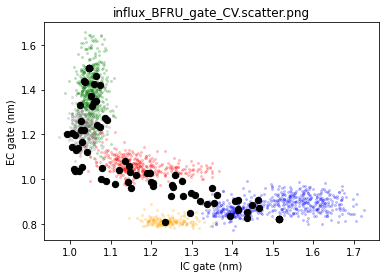

<Figure size 576x576 with 0 Axes>

In [8]:
f,ax = plt.subplots()

plot_G5_atomistic(ax, show_ends = False)
ax.scatter(IC/10, EC/10, color = 'black', s = 40)
ax.set_xlabel("IC gate (nm)")
ax.set_ylabel("EC gate (nm)")
ax.set_title(f"{condition}.scatter.png")

plt.show()

## For multiple conditions comparison
<a id='gate_group'></a>
right now I can only plot one iteration, I will fix this

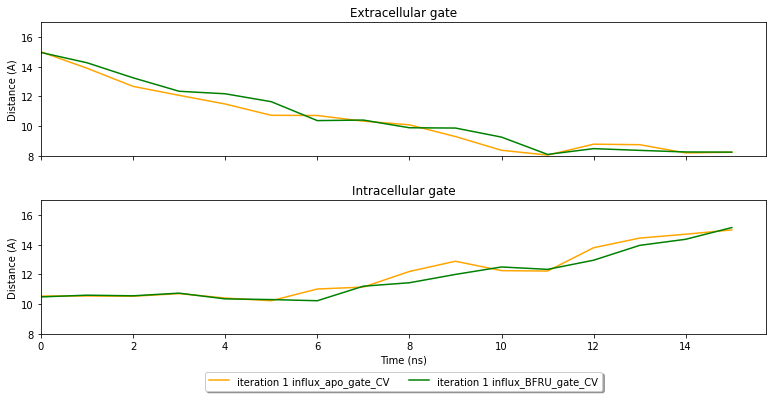

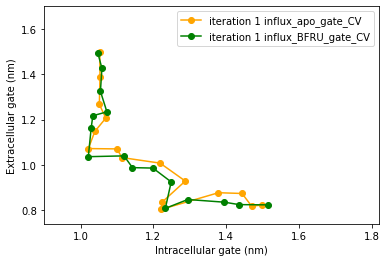

In [9]:
conditions = ['influx_apo_gate_CV', 'influx_BFRU_gate_CV']
#colors = ['green', 'orange']
colors = ['orange', 'green']
iteration = 0

EC_list = []
IC_list = []
for c in conditions:
    EC = conditions_gates[c][0][iteration]
    IC = conditions_gates[c][1][iteration]
    EC_list.append(EC)
    IC_list.append(IC)


EC_list = np.array(EC_list)
IC_list = np.array(IC_list)


gate_dist_over_time(
        EC_list = EC_list , 
        IC_list = IC_list ,
        color_list = colors ,
        label_list = [f"iteration {conditions_iterations[x][iteration]} " + x for x in conditions],
    )



plot_gate_scatter(EC_arr = EC_list , 
                   IC_arr = IC_list ,
                   color_list = colors,
                   label = [f"iteration {conditions_iterations[x][iteration]} " + x for x in conditions],)

In [10]:
conditions_gates[]

SyntaxError: invalid syntax (<ipython-input-10-056717ff5a19>, line 1)

Also make this GLUT5 atomisitic plot

In [ ]:
f,ax = plt.subplots()

plot_G5_atomistic(ax, show_ends = False)

ax.scatter(IC_list[0]/10, EC_list[0]/10, color = 'orange', s = 60, label = conditions[0], edgecolor = 'black')
ax.scatter(IC_list[1]/10, EC_list[1]/10, color = 'green', s = 60, label = conditions[1], edgecolor = 'black')

ax.set_xlabel("IC gate (nm)")
ax.set_ylabel("EC gate (nm)")
ax.set_title(f"{condition}.scatter.png")

plt.show()

<h1><center>Salt bridge contacts</h1></center>
<a id='salt_br'></a>


Salt bridge contacts in the simulations are:

**Bridge 1**:
  - E145+R91 always in contact, OF or IF (N term, TM 4 and 3) ( = E151,R97,R407 in paper)
  - R401 contacts when OF (TM11)
  
  
**Bridge 2:**
  - R334+E394 always in contact, OF or IF (C term, TM9 and 10) ( = R340,E400,E336,R158 in paper)
  - R152 contacts when OF(TM5)
  - E330 is on TM 8, might also coordinate

First run the needed gmx scripts

In [25]:
def get_salt_br_arr(condition, iteration):
    subprocess.call(f"./salt_bridge.sh {condition} {iteration}", shell = True)

    bridge_names=[
        'E145-R401',
        'E394-R152'
    ]

    bridge_arr = np.zeros((len(bridge_names), 16))


    for n, bridge_name in enumerate(bridge_names):
        bridge_arr[n] = np.loadtxt(f'../textfiles_out/salt_bridge_GMX/{condition}.{iteration}.{bridge_name}.xvg')[:,1] #skip time
    
    return bridge_arr, bridge_names

Plotting dist / bead per iteration

In [60]:
salt_br_dists = []
condition = 'efflux_BFRU_gate_CV'

for x in conditions_iterations[condition]:
    temp_arr = get_salt_br_arr(condition, str(x))
    salt_br_dists.append(temp_arr[0])
    bridge_names = temp_arr[1]    
    
salt_br_dists = np.array(salt_br_dists)

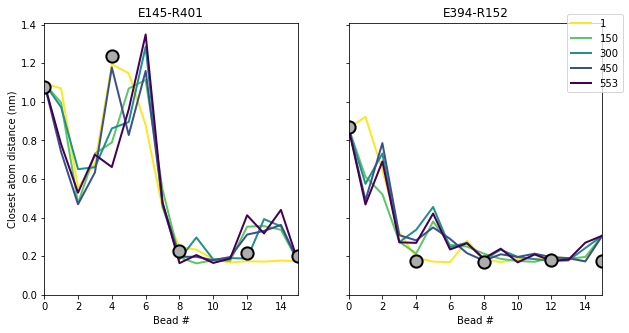

In [64]:
iter_index = slice(0, None, 3) 
salt_br_sliced = salt_br_dists[iter_index]

label_list = np.array([str(x) for x in conditions_iterations[condition]])[iter_index] 



colormap_colors = 'viridis_r'
cmap_vals = plt.cm.get_cmap(colormap_colors)
color_vals = cmap_vals(np.linspace(0,1,np.shape(salt_br_sliced)[0]))


f, (ax1,ax2) = plt.subplots(nrows = 1, ncols=2, figsize = (10,5), sharey = True)

for n,x in enumerate(salt_br_sliced):
    ax1.plot(x[0], color = color_vals[n], label = label_list[n], linewidth = 2,zorder=1)
    ax2.plot(x[1], color = color_vals[n], label = label_list[n], linewidth = 2,zorder=1)


    
models_bridge1 = np.loadtxt('../textfiles_out/salt_bridge_GMX/OUT-IN.E145-R401.xvg')[:,1]
models_bridge2 = np.loadtxt('../textfiles_out/salt_bridge_GMX/OUT-IN.E394-R152.xvg')[:,1]
ax1.scatter([0,4,8,12,15], models_bridge1, color = '#ADADAD', edgecolor = 'black', linewidth = 2, s = 150, zorder=2)
ax2.scatter([0,4,8,12,15], models_bridge2, color = '#ADADAD', edgecolor = 'black', linewidth = 2, s = 150, zorder=2)

    
ax2.legend(bbox_to_anchor=(1.1, 1.05))

ax1.set_xlim(0, 15)
ax2.set_xlim(0, 15)
ax1.set_ylim(0,)
ax2.set_ylim(0,)

ax1.set_ylabel("Closest atom distance (nm)")
ax1.set_xlabel("Bead #")
ax2.set_xlabel("Bead #")


ax1.set_title(bridge_names[0])
ax2.set_title(bridge_names[1])

plt.savefig(f'../images_figs/confout_file_analysis/salt_bridges/{condition}/across_iterations.png')

Comparing the final conditions of apo vs BFRU

In [18]:
conditions = ['influx_BFRU_gate_CV','influx_apo_gate_CV']
colors = ['green', 'orange']
iteration = ['552', '745']

bfru_bridge, bridge_names = get_salt_br_arr(conditions[0], iteration[0])
apo_bridge, bridge_names = get_salt_br_arr(conditions[1], iteration[1])

models_bridge1 = np.loadtxt('../textfiles_out/salt_bridge_GMX/OUT-IN.E145-R401.xvg')[:,1]
models_bridge2 = np.loadtxt('../textfiles_out/salt_bridge_GMX/OUT-IN.E394-R152.xvg')[:,1]

Can delete this one when you finish comparing efflux to influx

In [70]:
conditions = ['efflux_BFRU_start','influx_apo_gate_CV']
colors = ['blue', 'orange']
iteration = ['450', '745']

bridges_all = []

for name, it in zip(conditions, iteration):
    temp = get_salt_br_arr(name, it)
    bridges_all.append(temp[0])
    bridge_names = temp[1]
    print(name, it)

models_bridge1 = np.loadtxt('../textfiles_out/salt_bridge_GMX/OUT-IN.E145-R401.xvg')[:,1]
models_bridge2 = np.loadtxt('../textfiles_out/salt_bridge_GMX/OUT-IN.E394-R152.xvg')[:,1]

efflux_BFRU_start 450
influx_apo_gate_CV 745


Can delete this one when you finish comparing efflux to bfru efflux

In [58]:
conditions = ['influx_apo_gate_CV', 'influx_BFRU_gate_CV','efflux_BFRU_start','efflux_BFRU_gate_CV']
colors = ['orange', 'green', 'blue', 'purple']
iteration = ['745', '552', '450', '553']

#bfru_bridge, bridge_names = get_salt_br_arr(conditions[0], iteration[0])
#apo_bridge, bridge_names = get_salt_br_arr(conditions[1], iteration[1])
bridges_all = []

for name, it in zip(conditions, iteration):
    temp = get_salt_br_arr(name, it)
    bridges_all.append(temp[0])
    bridge_names = temp[1]
    print(name, it)

models_bridge1 = np.loadtxt('../textfiles_out/salt_bridge_GMX/OUT-IN.E145-R401.xvg')[:,1]
models_bridge2 = np.loadtxt('../textfiles_out/salt_bridge_GMX/OUT-IN.E394-R152.xvg')[:,1]

influx_apo_gate_CV 745
influx_BFRU_gate_CV 552
efflux_BFRU_start 450
efflux_BFRU_gate_CV 553


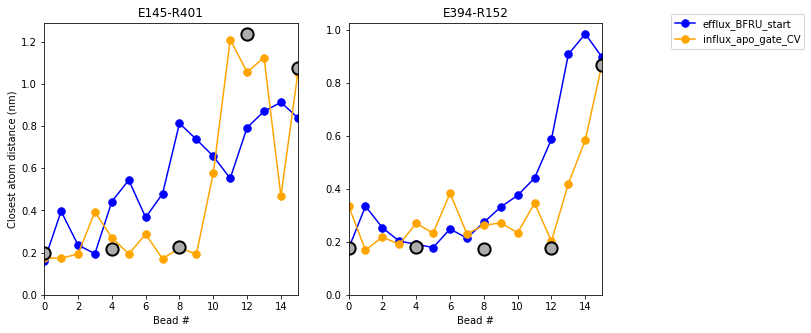

In [75]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

title_names = []

for n in range(0, len(conditions)):
    if 'efflux' in conditions[n]:
        bridge = np.fliplr(bridges_all[n])
    else:
        bridge = bridges_all[n]
    ax1.plot(bridge[0], color = colors[n], label = conditions[n], zorder = 1, linewidth = 1.5, marker=".", markersize=15)
    ax2.plot(bridge[1], color = colors[n], label = conditions[n], zorder = 1, linewidth = 1.5, marker=".", markersize=15)
    
    title_names.append(conditions[n])

ax1.scatter([0,4,8,12,15], models_bridge1, color = '#ADADAD', edgecolor = 'black', linewidth = 2, s = 150, zorder=2)
ax2.scatter([0,4,8,12,15], models_bridge2, color = '#ADADAD', edgecolor = 'black', linewidth = 2, s = 150, zorder=2)



lgd = ax2.legend(bbox_to_anchor=(1.25, 1.05))

ax1.set_xlim(0, 15)
ax2.set_xlim(0, 15)
ax1.set_ylim(0,)
ax2.set_ylim(0,)

ax1.set_ylabel("Closest atom distance (nm)")
ax1.set_xlabel("Bead #")
ax2.set_xlabel("Bead #")


ax1.set_title(bridge_names[0])
ax2.set_title(bridge_names[1])

plt.savefig(f'../images_figs/confout_file_analysis/salt_bridges/compare_conditions/{"-".join(title_names)}.png',\
         bbox_extra_artists=(lgd,), bbox_inches='tight' )
         


<h1><center>Contacts from Darko</h1></center>
<a id='Darko'></a>

 

From Zulip:

**Outward open - Outward occluded** 

**CV1 - enhanced in out open** : G174-A31, A196-I103, P186-S112, C372-A348, N318-V286 
<font color='grey'>(original 181G-38A 203A-110I 193P-119S 379C-355A 325N-293V)</font>


**CV2- enchanced in out occluded** : Q308-G174, A381-Q160, A381-T164, V128-F71, G315-Q171
<font color='grey'>(original 315Q-181G 388A-167Q 388A-171T 135V-78F 322G-178Q)</font>
 
 ***
 
**Outward occluded - Occluded** 

**CV1 - enhanced in out occluded**: G465-V68, Y290-A30, G315-Q171
<font color='grey'>427G-75V 297Y-37A 322G-178Q</font>


**CV2 - enhanced in fully occluded** : L390-V329, C345-S284, V236-K224, N318-V286, N416-V29, G383-L337, C372-A348 
<font color='grey'>397L-336V 352C-291S 243V-231K 325N-293V 423N-36V 390G-344L 379C-355A</font>


 *** 

**Inward occluded - Inward open**

**CV1 - enhanded in inward occluded** : Q344-G174, G317-Q171

<font color='grey'>315Q-181G 322G-178Q </font>

**CV2 - enhanced in fully inward** : L198-F19, E239-R231, I387-L337, P386-A325, F206-Y142, V236-K224, I122-T67, L390-V329, C372-A348
    
<font color='grey'>205L-26F 246E-238R 394I-344L 393P-332A 213F-149Y 243V-231K 129I-74T 397L-336V 379C-355A</font>

In [5]:
dict_ref_shading = {'OUTWARD_OPEN':(0,5), "OUTWARD_OCCLUDED":(4,9), "INWARD_OCCLUDED":(12,15)} #so you can shade area of interest in graph
dict_cv1_cv2_lengths = {'OUTWARD_OPEN':(5,5), "OUTWARD_OCCLUDED":(3,7), "INWARD_OCCLUDED":(2,9)}

In [6]:
def get_darko_dist_arr(condition, iteration, cv_group, return_models = None):
    
    contacts_cv1_groups = {
                        'OUTWARD_OPEN':[('174_HN','31_HA'), ('196_HB1','103_HG11'), ('186_HD2','112_HG1')\
                                        , ('372_O','348_HB2'), ('318_OD1','286_HG11')],
                         "OUTWARD_OCCLUDED":[('465_HA','68_HG13'), ('290_HB1','30_HB2'), ('315_HA1','171_HG1')],
                         "INWARD_OCCLUDED":[('344_HG21','174_HA1'), ('317_HA','171_HG1')]
                          }
    
    contacts_cv2_groups = {
                    'OUTWARD_OPEN':[('308_HB1','174_O'), ('381_O','160_HB1'), ('381_HB2','164_HG22'),\
                                    ('128_O','71_CD1'), ('315_HA1','171_HG1')],
                     "OUTWARD_OCCLUDED":[('390_HD11','329_HG22'), ('345_HB2','284_HB2'), ('236_HG22','224_HN'), \
                                         ('318_OD1','286_HG23'), ('416_OD1','29_HG21'), ('383_HA2','337_O'), ('372_O','348_HB1')],
                     "INWARD_OCCLUDED":[('198_O','19_HD2'), ('239_O','231_HB1'), ('387_HB','337_HD21'), ('386_HD1','325_HN'),\
                                        ('206_CD2','142_OH'), ('236_HG21','224_HG2'), ('122_HG21','67_OG1'), \
                                        ('390_HD22','329_HG21'), ('372_HB1','348_HB2')]
                      }
    
    scores_cvs = {'OUTWARD_OPEN':[0.2394941214441451, 0.17863718195954076, 0.22829366907512316,\
                                  0.19946214152438158, 0.15411288599680942, 0.2229487221925901, \
                                  0.22352902476893688, 0.1541859413566841, 0.15980437637399936, 0.23953193530778957],
                  
                 'OUTWARD_OCCLUDED':[0.36805920033218326, 0.2764556145667593, 0.3554851851010575, \
                                     0.140953252458209, 0.1772870039340966, 0.13652678227951054, \
                                     0.116917466261338, 0.11464804932410656, 0.17362681856969972, 0.14004062717303947],
                  
                 'INWARD_OCCLUDED':[0.488214651736396, 0.5117853482636041, 0.1294970260086535,\
                                    0.1155039966361535, 0.1255693377498144, 0.11155992278130479,\
                                    0.08760322976066104, 0.09880977669901195, 0.10682457260253515,\
                                    0.12239235626633586, 0.10223978149552974]}

    
    contact_names = contacts_cv1_groups[cv_group]+contacts_cv2_groups[cv_group]
    raw_contact_arr = np.zeros((len(contact_names), 16))
    scored_contact_arr = np.zeros((len(contact_names), 16))
    model_arr = np.zeros((len(contact_names), 5))
    
    n=0
    for contact1,contact2 in contacts_cv1_groups[cv_group]:
        resid1, atomid1 = contact1.split('_')
        resid2, atomid2 = contact2.split('_')
    
        print(f"testing for {condition} {iteration} {cv_group} {resid1} {atomid1} {resid2} {atomid2}")
        
        
        subprocess.call(f"./darko_dists.sh {condition} {iteration} {cv_group} {resid1} {atomid1} {resid2} {atomid2}", shell = True)
        temp = np.loadtxt(f"../textfiles_out/darko_dists_GMX/{cv_group}/{condition}.{iteration}.{resid1}-{resid2}.xvg")[:,1]
        raw_contact_arr[n] = temp
        scored_contact_arr[n] = temp * scores_cvs[cv_group][n]
        model_arr[n] = np.loadtxt(f"../textfiles_out/darko_dists_GMX/{cv_group}/OUT-IN.{resid1}-{resid2}.xvg")[:,1]
        n = n+1
    
    for contact1,contact2 in contacts_cv2_groups[cv_group]:
        resid1, atomid1 = contact1.split('_')
        resid2, atomid2 = contact2.split('_')
        subprocess.call(f"./darko_dists.sh {condition} {iteration} {cv_group} {resid1} {atomid1} {resid2} {atomid2}", shell = True)
        temp = np.loadtxt(f"../textfiles_out/darko_dists_GMX/{cv_group}/{condition}.{iteration}.{resid1}-{resid2}.xvg")[:,1]
        raw_contact_arr[n] = temp
        scored_contact_arr[n] = temp * scores_cvs[cv_group][n]
        model_arr[n] = np.loadtxt(f"../textfiles_out/darko_dists_GMX/{cv_group}/OUT-IN.{resid1}-{resid2}.xvg")[:,1]
        n = n+1
    
    
    if return_models:
        return contact_names, scored_contact_arr, raw_contact_arr, model_arr
    else:
        return contact_names, scored_contact_arr, raw_contact_arr

Plotting contacts / condition over several iterations

In [ ]:
contacts_all = []
scores_contacts_all = []

condition = 'influx_apo_gate_CV'
cv_group = "INWARD_OCCLUDED"
for x in conditions_iterations[condition]:
    temp_arr = get_darko_dist_arr(condition, str(x), cv_group)
    scores_contacts_all.append(temp_arr[1])
    contacts_all.append(temp_arr[2])
    contact_names = temp_arr[0]
    
contacts_all = np.array(contacts_all)
scores_contacts_all = np.array(scores_contacts_all)




testing for influx_apo_gate_CV 1 INWARD_OCCLUDED 344 HG21 174 HA1
testing for influx_apo_gate_CV 1 INWARD_OCCLUDED 317 HA 171 HG1
testing for influx_apo_gate_CV 50 INWARD_OCCLUDED 344 HG21 174 HA1
testing for influx_apo_gate_CV 50 INWARD_OCCLUDED 317 HA 171 HG1
testing for influx_apo_gate_CV 100 INWARD_OCCLUDED 344 HG21 174 HA1
testing for influx_apo_gate_CV 100 INWARD_OCCLUDED 317 HA 171 HG1
testing for influx_apo_gate_CV 150 INWARD_OCCLUDED 344 HG21 174 HA1
testing for influx_apo_gate_CV 150 INWARD_OCCLUDED 317 HA 171 HG1
testing for influx_apo_gate_CV 200 INWARD_OCCLUDED 344 HG21 174 HA1
testing for influx_apo_gate_CV 200 INWARD_OCCLUDED 317 HA 171 HG1
testing for influx_apo_gate_CV 250 INWARD_OCCLUDED 344 HG21 174 HA1
testing for influx_apo_gate_CV 250 INWARD_OCCLUDED 317 HA 171 HG1
testing for influx_apo_gate_CV 300 INWARD_OCCLUDED 344 HG21 174 HA1
testing for influx_apo_gate_CV 300 INWARD_OCCLUDED 317 HA 171 HG1
testing for influx_apo_gate_CV 350 INWARD_OCCLUDED 344 HG21 174 HA1


Plotting all contacts

In [48]:
cv1 = scores_contacts_all[:,0:dict_cv1_cv2_lengths[cv_group][0]]
cv2 = scores_contacts_all[:,dict_cv1_cv2_lengths[cv_group][0]:]

iteration = 0

test1 = cv1[iteration]  #trying with just one iteration
test2 = cv2[iteration]

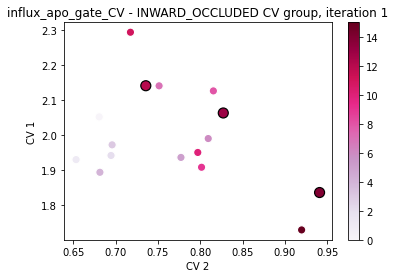

In [49]:
cv1_sum = np.sum(test1, axis = 0)
cv2_sum = np.sum(test2, axis = 0)

cv1_sum_relevant = cv1_sum[dict_ref_shading[cv_group][0]:dict_ref_shading[cv_group][1]]
cv2_sum_relevant = cv2_sum[dict_ref_shading[cv_group][0]:dict_ref_shading[cv_group][1]]

cm = plt.cm.get_cmap('PuRd')


sizes = np.ones(len(cv2_sum)) * 70
sizes[dict_ref_shading[cv_group][0]:dict_ref_shading[cv_group][1]] = 100


edgecolors = np.repeat('white', len(cv2_sum))
edgecolors[dict_ref_shading[cv_group][0]:dict_ref_shading[cv_group][1]] = 'black'


t = plt.scatter(cv2_sum, cv1_sum, c = np.arange(0, len(cv2_sum)), s = sizes, edgecolor = edgecolors,\
                linewidth = 1.2, cmap = cm)



plt.xlabel('CV 2')
plt.ylabel('CV 1')

plt.title(f"{condition} - {cv_group} CV group, iteration {conditions_iterations[condition][iteration]}")

plt.colorbar(t)

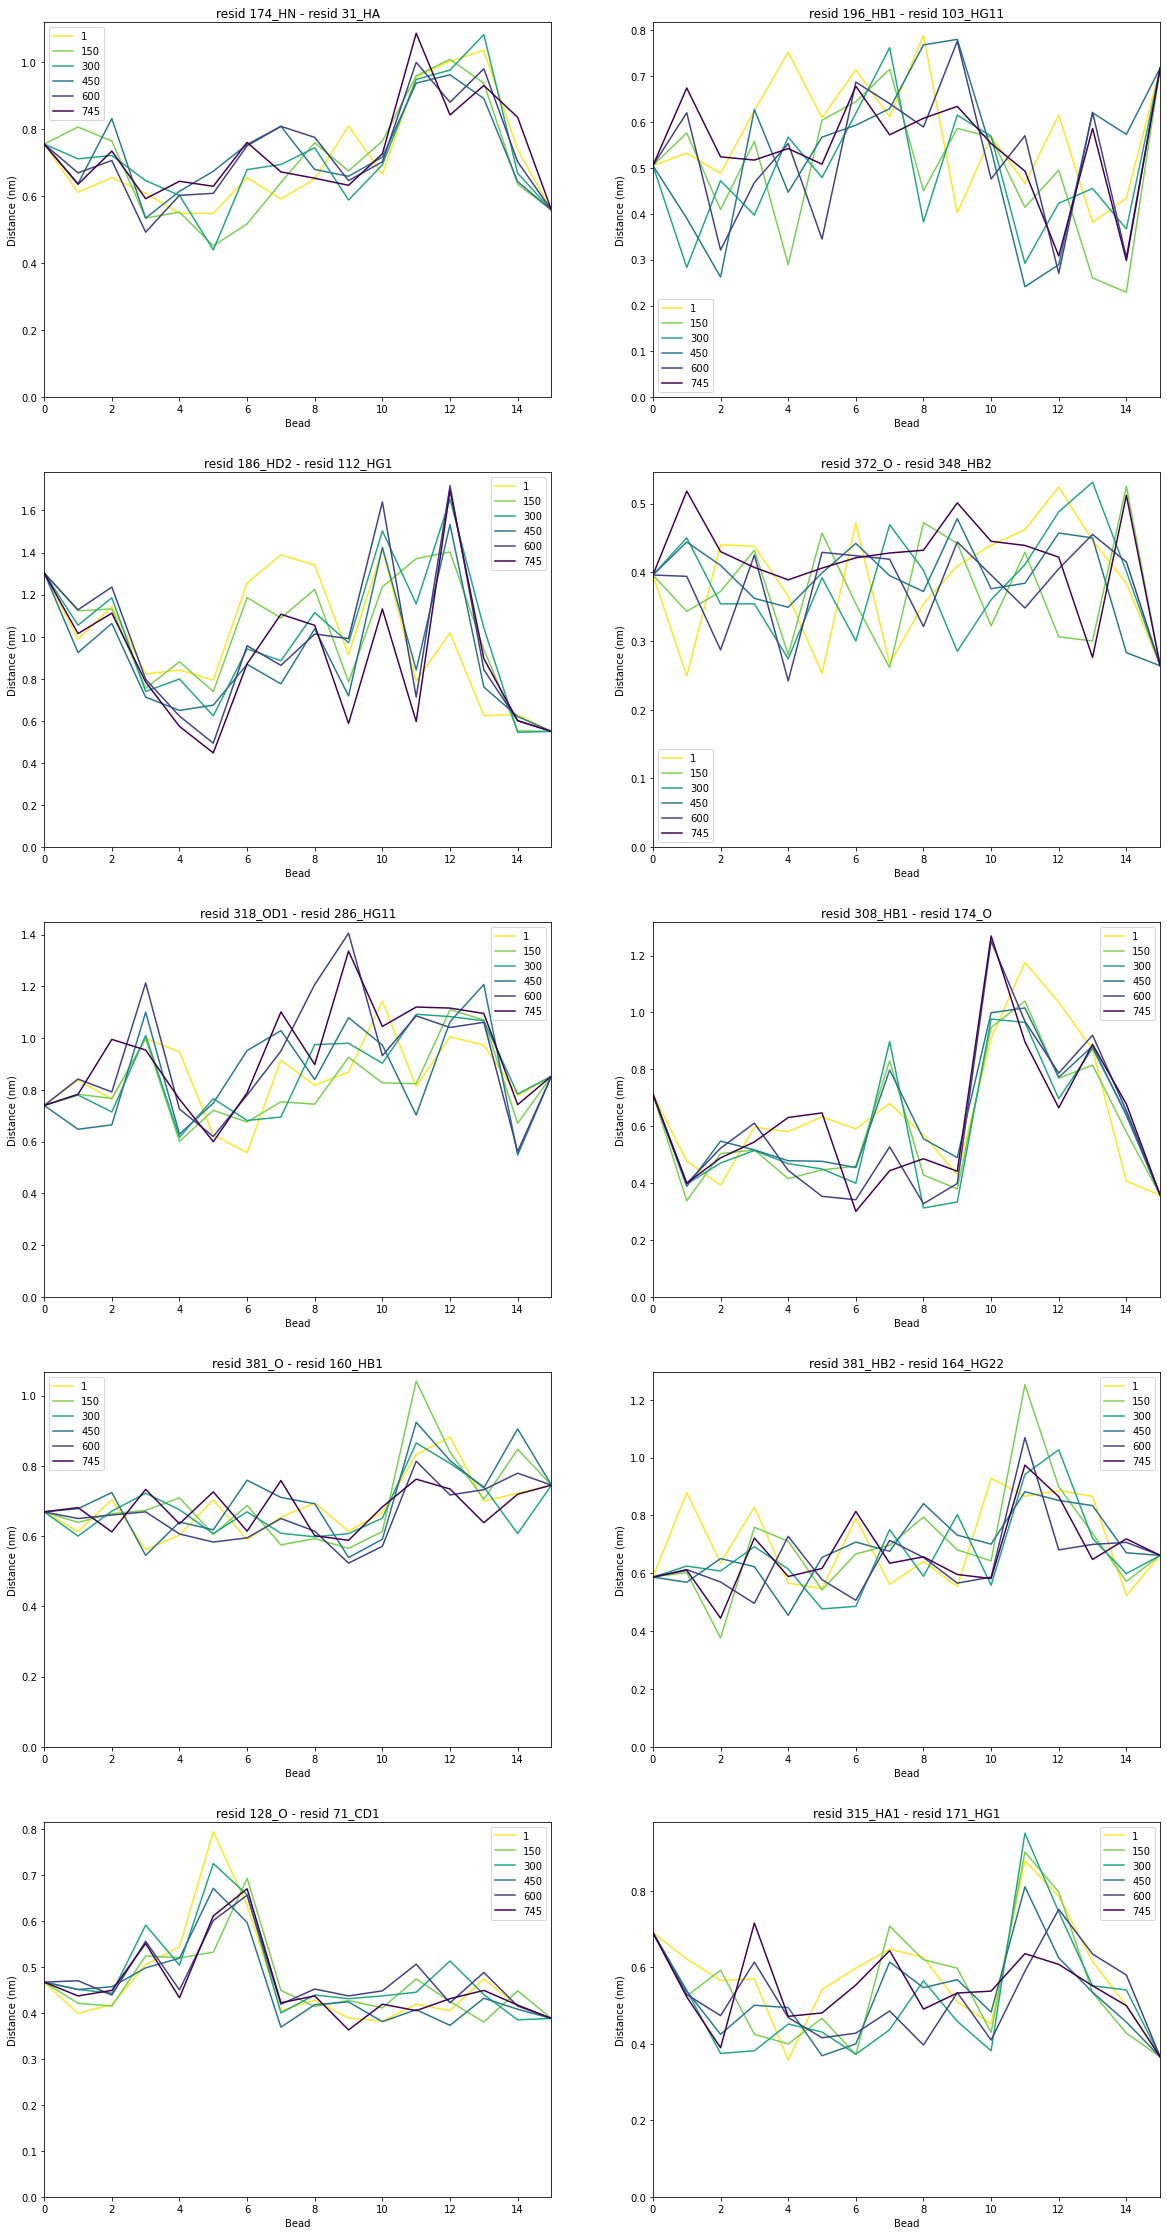

In [161]:
iter_index = slice(0, None, 3) 
contacts_all_sliced = contacts_all[iter_index]

label_list = np.array([str(x) for x in conditions_iterations[condition]])[iter_index] 



colormap_colors = 'viridis_r'
cmap_vals = plt.cm.get_cmap(colormap_colors)
color_vals = cmap_vals(np.linspace(0,1,np.shape(contacts_all_sliced)[0]))




n_plots = len(contact_names)
fig, ax = plt.subplots(ceil(n_plots / 2), 2, figsize=(20, 8 * ceil(n_plots / 2)))
ax = ax.flatten()

for contact_index, axs in enumerate(ax):
    
    for iteration_index, iteration in enumerate(contacts_all_sliced): # loop through each iteration
        axs.plot(iteration[contact_index], color = color_vals[iteration_index], label = label_list[iteration_index])            # plot one cv contact per axis
    
    
    axs.set_title(f"resid {contact_names[contact_index][0]} - resid {contact_names[contact_index][1]}")
    axs.set_ylabel("Distance (nm)")
    axs.set_xlabel("Bead")
    axs.set_xlim(0,15)
    axs.set_ylim(0)
    
    axs.legend()    
    

Compare apo and BFRU 

In [50]:
conditions = ['influx_BFRU_gate_CV','influx_apo_gate_CV']
colors = ['#A4E4D0', '#FFCCB3','green', 'orange']
iteration = ['1', '1', '552', '745']

#cv_group = "OUTWARD_OPEN"

names, trash1, BFRU_contacts_start = get_darko_dist_arr(conditions[0], iteration[0], cv_group)
names, trash1, apo_contacts_start = get_darko_dist_arr(conditions[1], iteration[1], cv_group)
names, trash1, BFRU_contacts_end = get_darko_dist_arr(conditions[0], iteration[2], cv_group)
names, trash1,  apo_contacts_end = get_darko_dist_arr(conditions[1], iteration[3], cv_group)

names, trash1, trash2, models_contacts = get_darko_dist_arr(conditions[1], iteration[1], cv_group, return_models=True)

testing for influx_BFRU_gate_CV 1 INWARD_OCCLUDED 344 HG21 174 HA1
testing for influx_BFRU_gate_CV 1 INWARD_OCCLUDED 317 HA 171 HG1
testing for influx_apo_gate_CV 1 INWARD_OCCLUDED 344 HG21 174 HA1
testing for influx_apo_gate_CV 1 INWARD_OCCLUDED 317 HA 171 HG1
testing for influx_BFRU_gate_CV 552 INWARD_OCCLUDED 344 HG21 174 HA1
testing for influx_BFRU_gate_CV 552 INWARD_OCCLUDED 317 HA 171 HG1
testing for influx_apo_gate_CV 745 INWARD_OCCLUDED 344 HG21 174 HA1
testing for influx_apo_gate_CV 745 INWARD_OCCLUDED 317 HA 171 HG1
testing for influx_apo_gate_CV 1 INWARD_OCCLUDED 344 HG21 174 HA1
testing for influx_apo_gate_CV 1 INWARD_OCCLUDED 317 HA 171 HG1


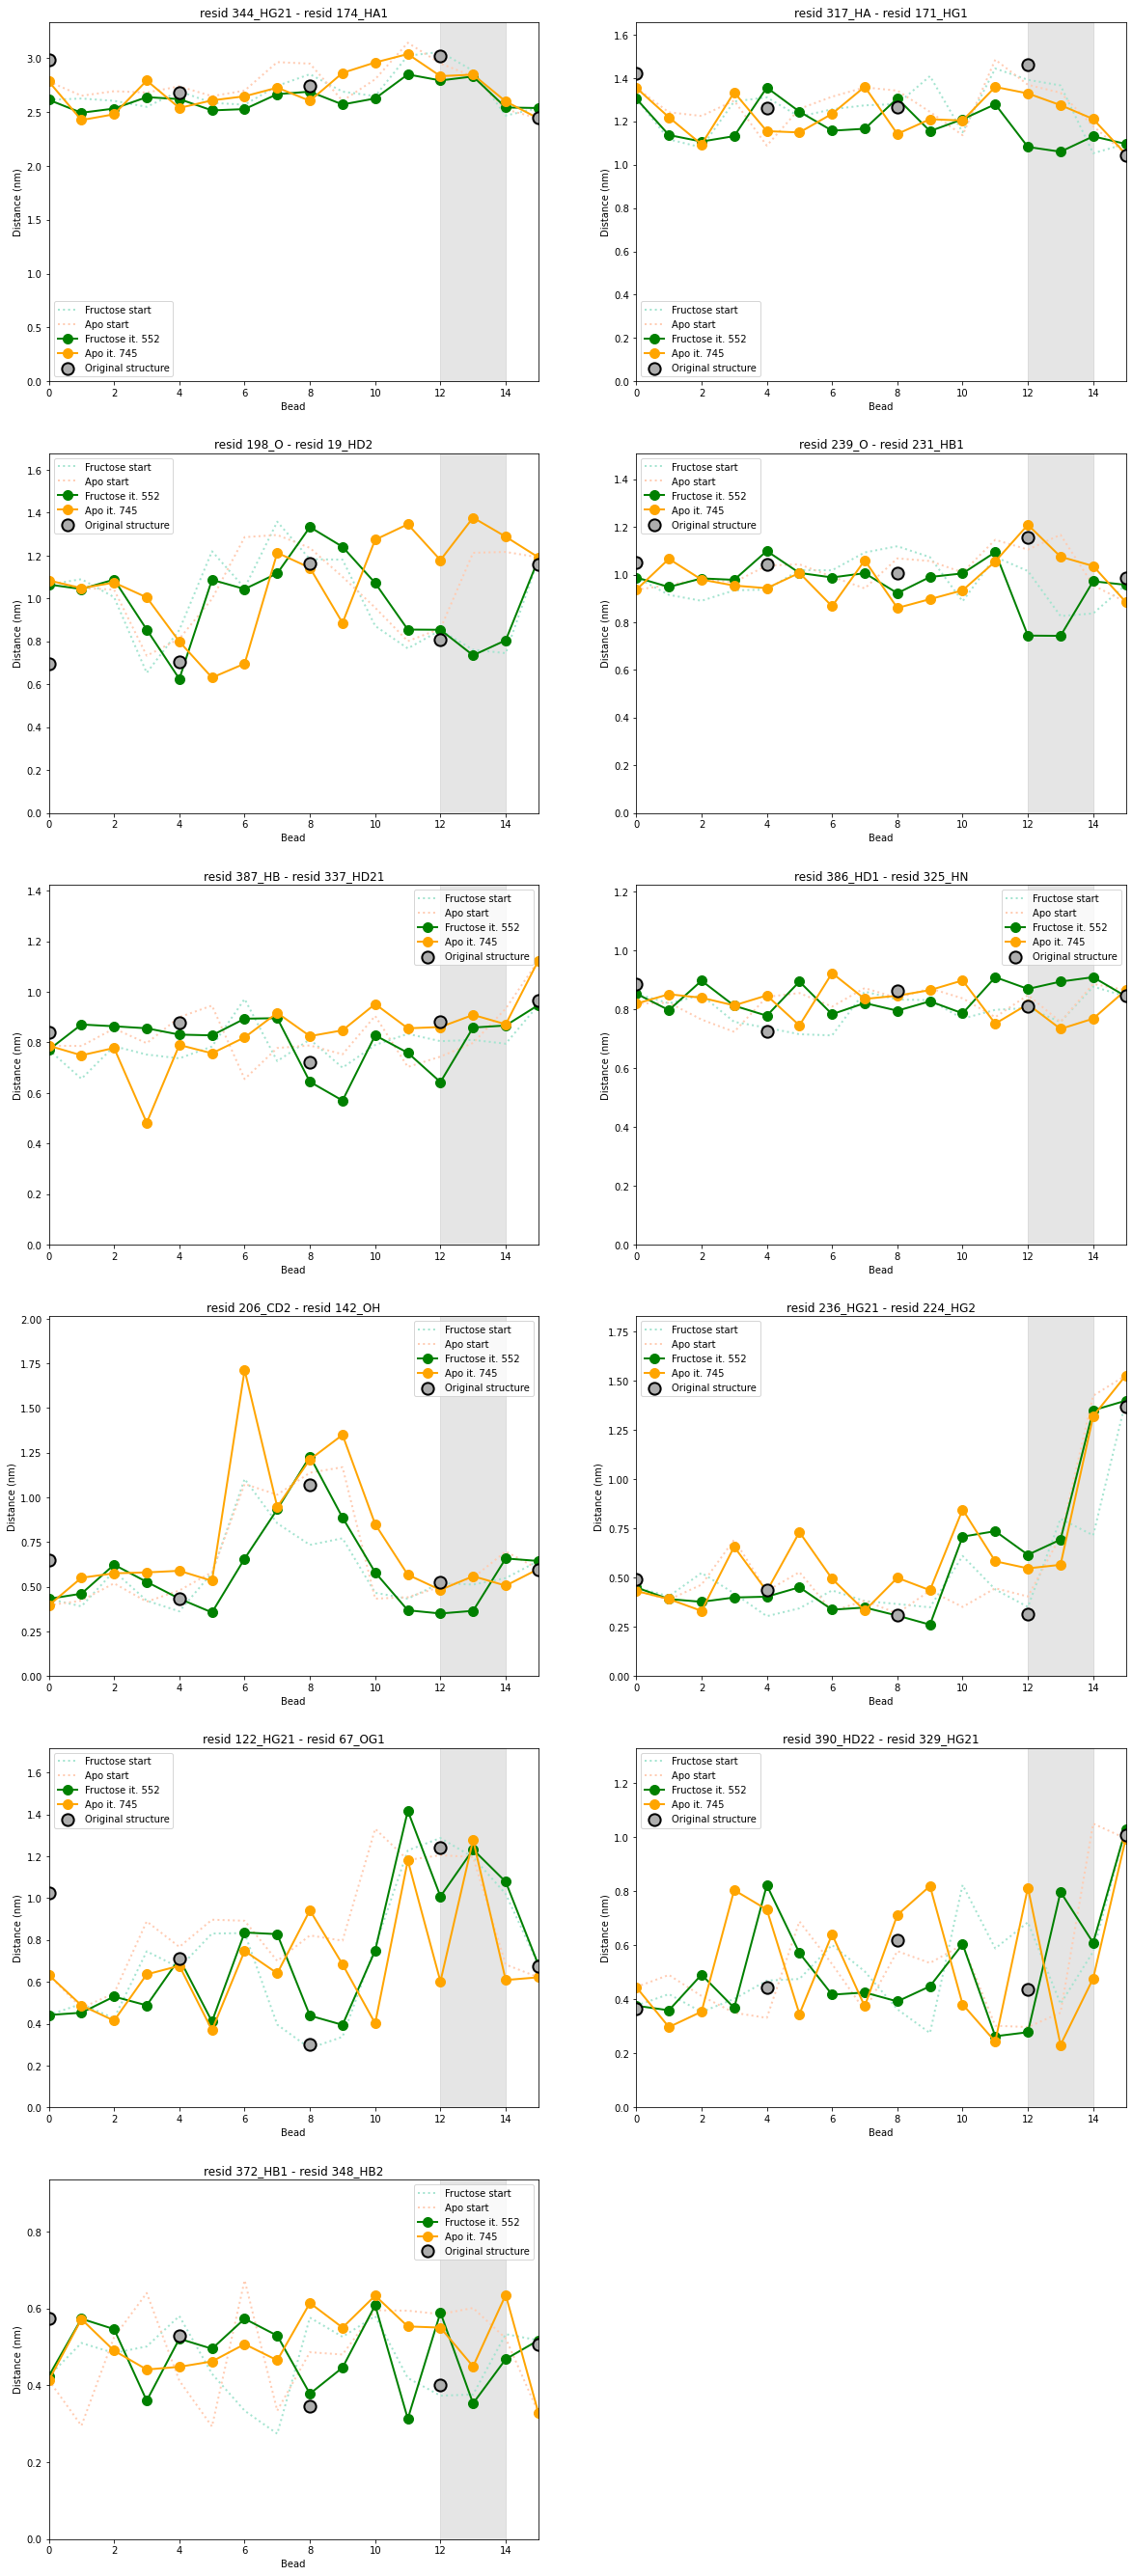

In [51]:
n_plots = len(names)
fig, ax = plt.subplots(ceil(n_plots / 2), 2, figsize=(20, 8 * ceil(n_plots / 2)))
ax = ax.flatten()

linewidth = 2
if n_plots % 2:
    fig.delaxes(ax[-1])   
    ax = ax[:-1]
    
for contact_index, axs in enumerate(ax):
    axs.plot(BFRU_contacts_start[contact_index], color = colors[0], label = "Fructose start",\
             zorder =1, linewidth = linewidth, linestyle = 'dotted')
    axs.plot(apo_contacts_start[contact_index], color = colors[1], label = "Apo start", \
             zorder =1, linewidth = linewidth, linestyle = 'dotted')
    axs.plot(BFRU_contacts_end[contact_index], color = colors[2], label = "Fructose it. 552", \
             zorder =1, linewidth = linewidth, marker=".", markersize=20)
    axs.plot(apo_contacts_end[contact_index], color = colors[3], label = "Apo it. 745", \
             zorder =1, linewidth = linewidth, marker=".", markersize=20)
    
    axs.scatter([0,4,8,12,15], models_contacts[contact_index],color = '#ADADAD',\
                edgecolor = 'black', linewidth = 2, s = 150, zorder=2, label = "Original structure")

    ### add a reference of interesting area
    max1 = max(BFRU_contacts_end[contact_index])
    max2 = max(apo_contacts_end[contact_index])
    max_yval = max(max1,max2) + 0.3
    axs.fill_between(range(dict_ref_shading[cv_group][0],dict_ref_shading[cv_group][1]), 0, max_yval , alpha=0.2, color = 'grey')

    
    axs.set_title(f"resid {names[contact_index][0]} - resid {names[contact_index][1]}")
    axs.set_ylabel("Distance (nm)")
    axs.set_xlabel("Bead")
    axs.set_xlim(0,15)
    axs.set_ylim(0, max_yval)
    
    axs.legend()    
    


Plotting the delta of the contacts for the relevant states:

In [52]:
def plot_delta(contacts_arr, names, cv_group, ax, color, label):
    # I want to color by cv1 or cv2

    diffs_contacts = []
    for contact in contacts_arr:
        diffs_contacts.append(contact[dict_ref_shading[cv_group][0]] - contact[dict_ref_shading[cv_group][1]])


    ax.scatter(np.arange(0, len(diffs_contacts)), diffs_contacts, s = 40, color = color, label = label)

    
    #plot line across 0
    ax.plot(np.arange(-1, len(diffs_contacts)+1), np.zeros(len(diffs_contacts)+2), color = 'grey',\
            linestyle = 'dotted', linewidth = 0.5)
    #plot line splitting CV1 and CV2
    ax.plot(np.ones((10)) * dict_cv1_cv2_lengths[cv_group][0]-0.5, np.linspace(min(diffs_contacts), max(diffs_contacts), 10)\
            , linestyle = 'dotted', linewidth = 0.5, color = 'grey')
    
    ax.set_xlim(-1, len(diffs_contacts))


    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = names

    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation = 90)

    ax.set_ylabel("Delta distance (nm)")
    ax.legend()
    ax.set_title(f"{cv_group} CVs: start (bead {dict_ref_shading[cv_group][0]}) - finish (bead {dict_ref_shading[cv_group][1]})")

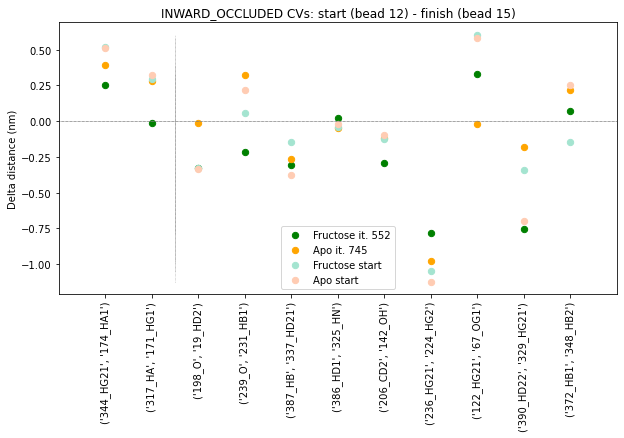

In [53]:
f,ax1 = plt.subplots(figsize = (10,5))

plot_delta(contacts_arr = BFRU_contacts_end, names = names, cv_group = cv_group,\
           ax = ax1, color = 'green', label = 'Fructose it. 552')
plot_delta(contacts_arr = apo_contacts_end, names = names, cv_group = cv_group,\
           ax = ax1, color = 'orange', label = "Apo it. 745")


plot_delta(contacts_arr = BFRU_contacts_start, names = names, cv_group = cv_group,\
           ax = ax1, color = '#A4E4D0', label = 'Fructose start')
plot_delta(contacts_arr = apo_contacts_start, names = names, cv_group = cv_group,\
           ax = ax1, color = '#FFCCB3', label = "Apo start")

Now plotting as CV1 and CV2

<h1><center>TM7B breakage</h1></center>
<a id='TM7b'></a>


<h1><center>RMSD to original model</h1></center>
<a id='RMSD'></a>


In [71]:
modeldir = '../../../steered/analysis/ref_models'

model_names = ["OUT.equilib.200ns", "OUT-OCC.start", "OCC.start", "IN-OCC.start", "IN.start"]
color_l = ["red", "blue", "green", "orange", "pink"]

model_l = []
for model in model_names:
    model_l.append(mda.Universe(f"{modeldir}/{model}.gro"))

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/topology/base.py:203: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  residx = np.zeros_like(criteria[0], dtype=np.int)


In [72]:
import MDAnalysis.analysis.rms

def calc_model_RMSD(model, traj):
    RMSD = MDAnalysis.analysis.rms.RMSD(reference=model.select_atoms("protein"), \
                                        atomgroup = traj.select_atoms("protein"), \
                                        center = True, select="backbone", \
            groupselections=["backbone and (resid 1-51 or resid 265-300 or resid 118-146 or resid 364-395)",\
                             "backbone and (resid 1-205 or resid 265-455)",\
                             "resid 30-37 or resid 289-295 or resid 136-145 or resid 386-394"])  #3,4,5 on rmsd

    RMSD.run(0)
    rmsd = RMSD.rmsd.T
    return rmsd

Comparing conditions over entire beads:

In [82]:
BFRU_start = []
apo_start = []
BFRU_final = []
apo_final = []

for model in model_l:
    BFRU_start.append(calc_model_RMSD(model, conditions_universes['influx_BFRU_gate_CV'][0]))
    apo_start.append(calc_model_RMSD(model, conditions_universes['influx_apo_gate_CV'][0]))
    BFRU_final.append(calc_model_RMSD(model, conditions_universes['influx_BFRU_gate_CV'][-1]))
    apo_final.append(calc_model_RMSD(model, conditions_universes['influx_apo_gate_CV'][-1]))    

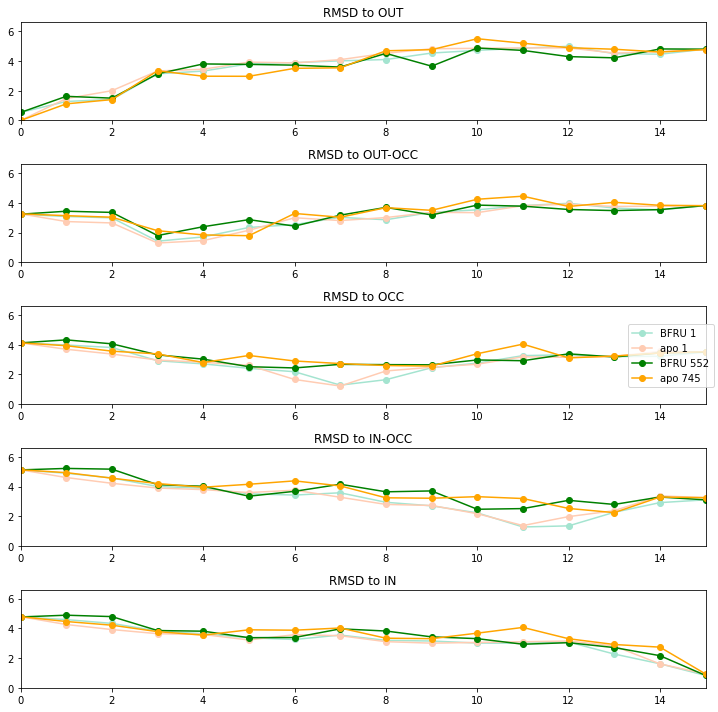

In [115]:
fig, axs = plt.subplots(nrows = 5, figsize = (10,10))
color_l = ['#A4E4D0', '#FFCCB3','green', 'orange']
label_l = ['BFRU 1', 'apo 1', 'BFRU 552', 'apo 745']
all_rmsd = [BFRU_start, apo_start, BFRU_final, apo_final]

## 2 = all protein. 3 = gating helices, 4 = all TMs, 5 = gating residues
rmsd_select = 5

ylim = (0,6)

for simulation_index, rmsd_to_model in enumerate(all_rmsd):
    for ax_loc, model in enumerate(rmsd_to_model):  #loop through model by model
        axs[ax_loc].plot(model[rmsd_select], marker = 'o', label = label_l[simulation_index], \
                         color = color_l[simulation_index])
        axs[ax_loc].set_title(f"RMSD to {model_names[ax_loc].split('.')[0]}")
    
for x in plt.gcf().get_axes():
    x.set_xlim(0,15)
    x.set_ylim(0,6.6)

    
plt.tight_layout()
handles, labels = axs[4].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

<h1><center>Hydration along Z</h1></center>
<a id='hydration'></a>


In [120]:
test = mda.Universe('../confout_files/measure_per_iteration/whole_systems/influx_apo_gate_CV.100.string.pdb')

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:330: UserWarning: Element information is absent or missing for a few atoms. Elements attributes will not be populated.
  warnings.warn("Element information is absent or missing for a few "
/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/topology/base.py:203: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  residx = np.zeros_like(criteria[0], dtype=np.int)


In [140]:
protein = test.select_atoms('protein')
protein_COM = protein.center_of_mass()
water = test.select_atoms('name OH2 and around 5 protein', updating = True)


D = density.DensityAnalysis(water, delta=1.0, gridcenter = protein_COM, xdim=100, ydim=100, zdim=100)
D.run(start = 0, stop = 15)
D.density.convert_density('TIP3P')

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/analysis/density.py:407: UserWarning: Box padding (currently set at 2.0) is not used in user defined grids.
  warnings.warn(msg)
/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/analysis/density.py:837: UserWarning: Atom selection does not fit grid --- you may want to define a larger box
  warnings.warn(msg)
/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/coordinates/base.py:865: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


In [141]:
D.frames

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [154]:
print(D.density.grid[:,:,24])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


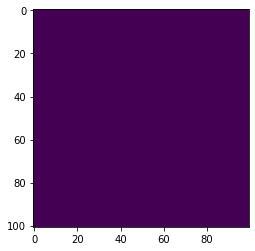

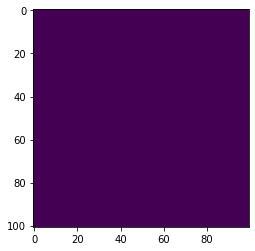

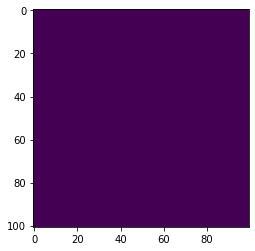

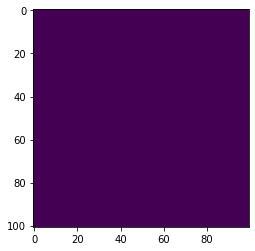

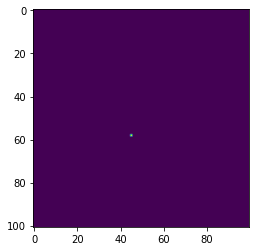

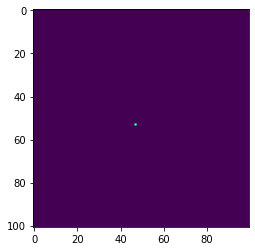

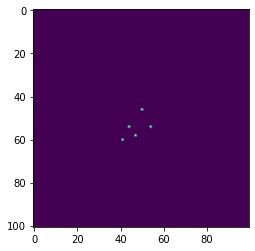

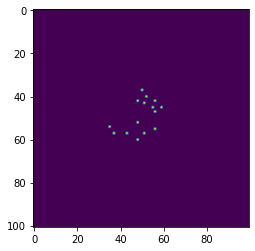

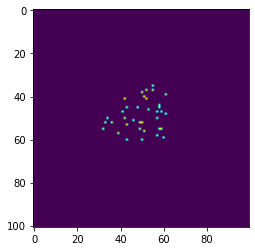

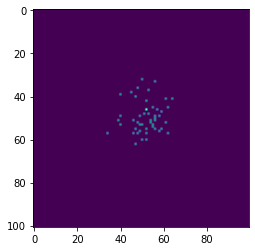

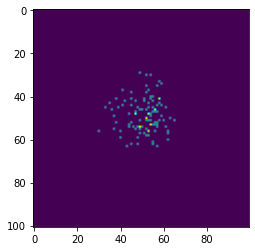

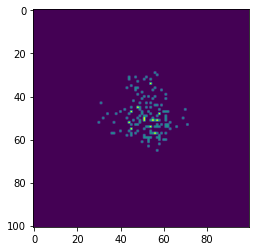

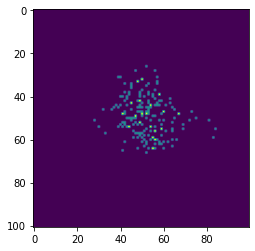

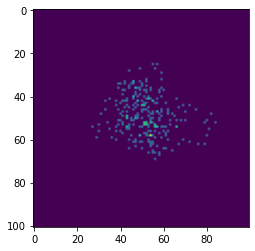

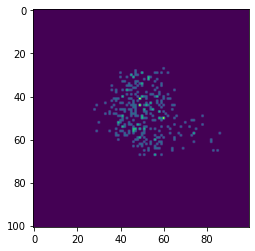

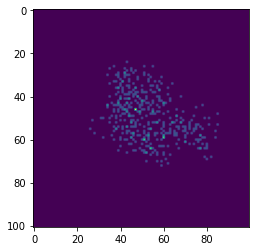

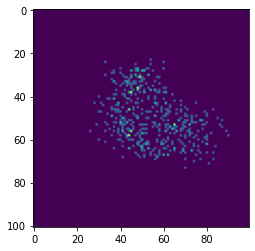

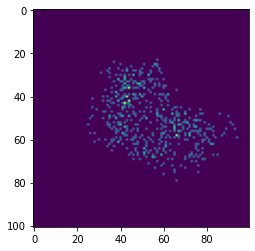

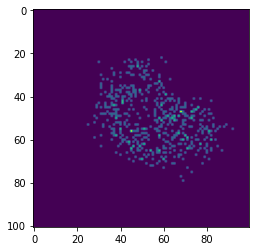

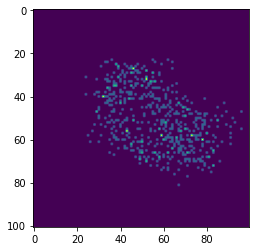

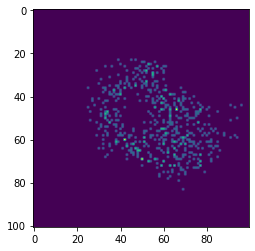

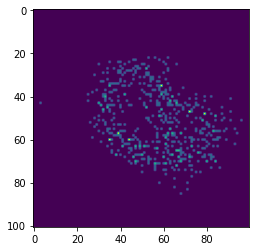

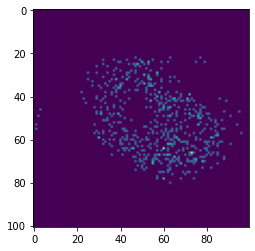

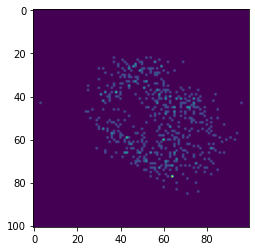

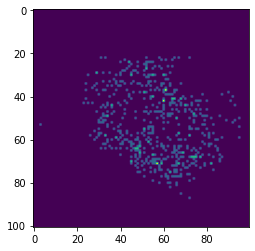

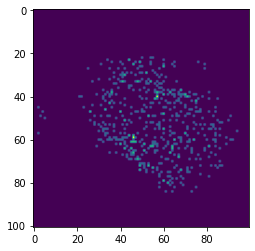

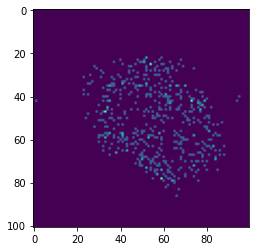

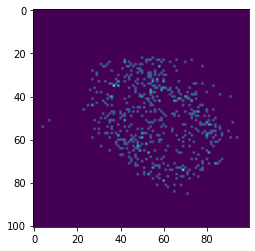

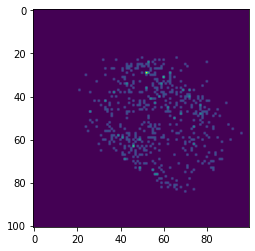

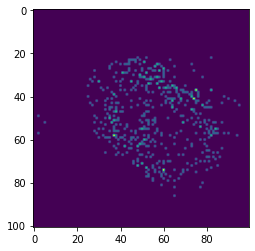

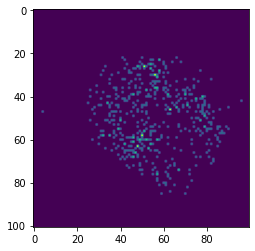

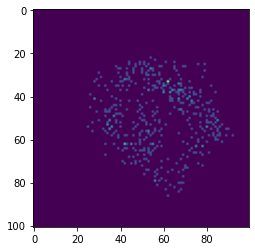

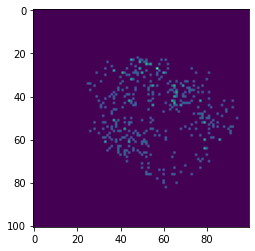

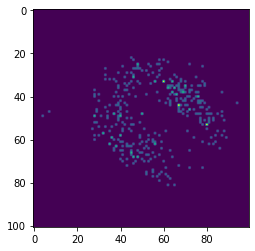

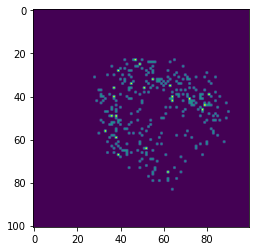

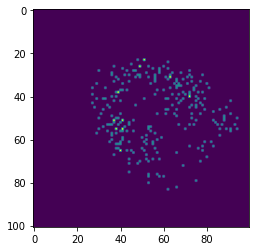

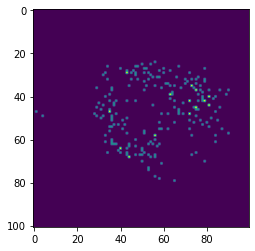

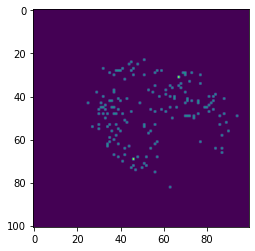

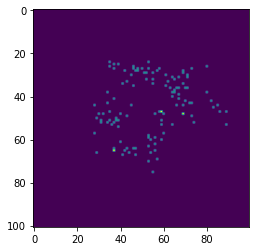

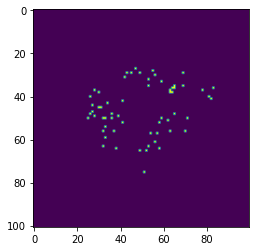

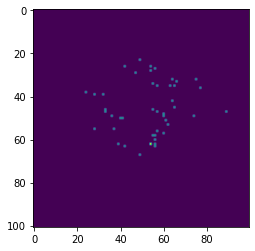

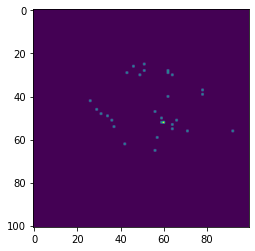

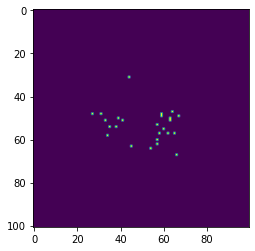

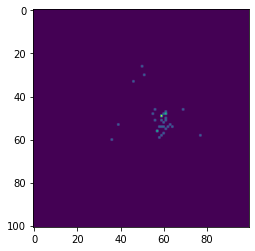

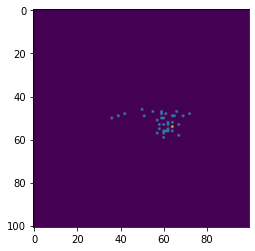

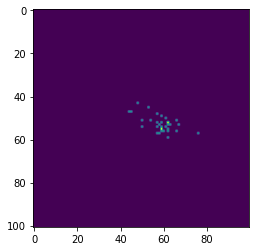

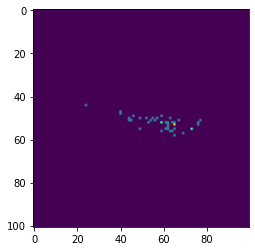

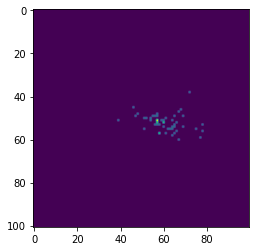

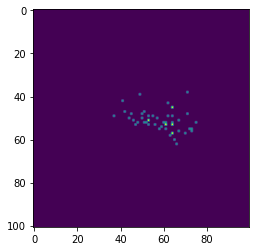

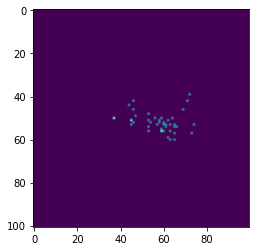

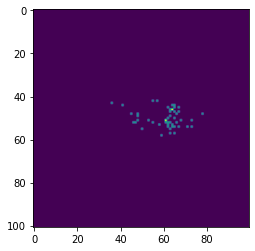

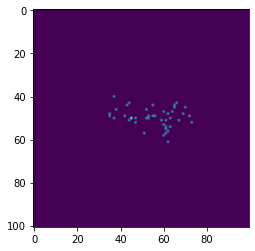

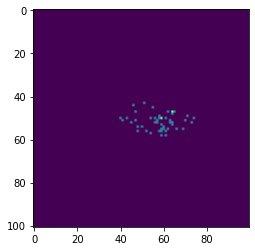

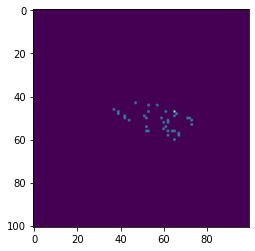

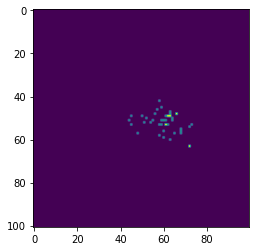

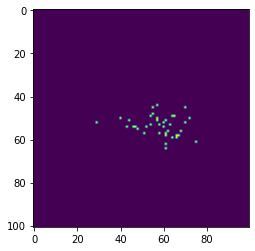

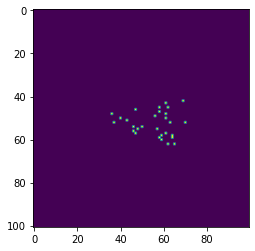

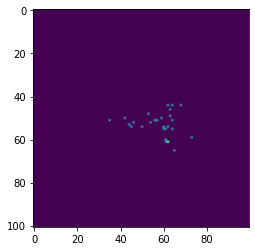

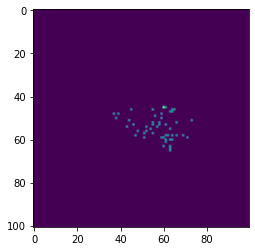

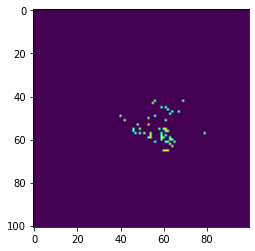

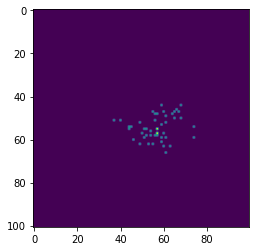

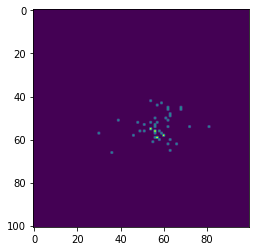

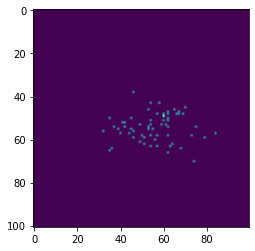

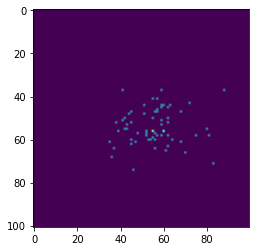

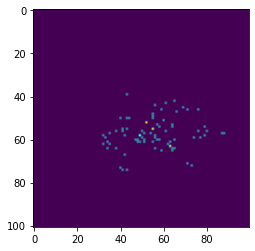

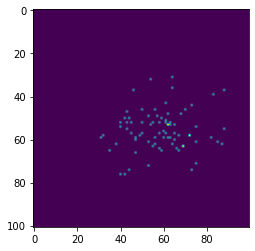

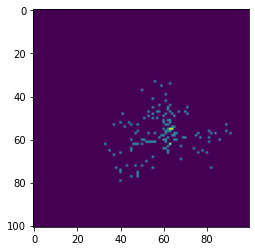

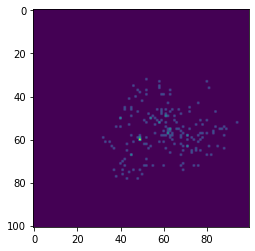

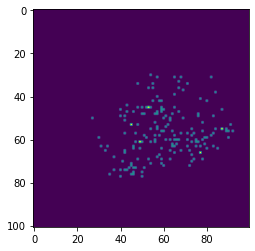

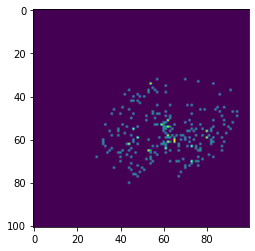

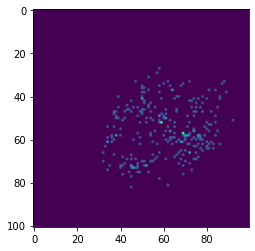

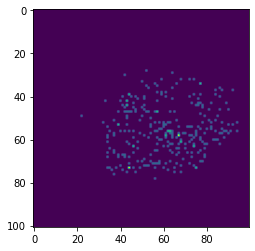

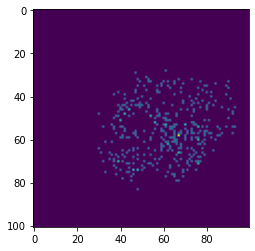

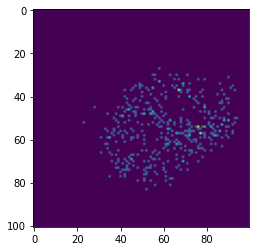

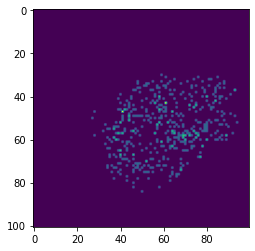

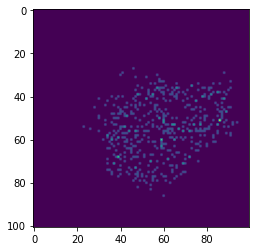

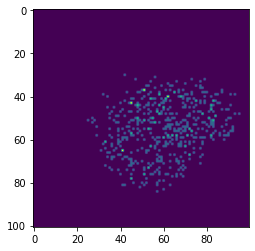

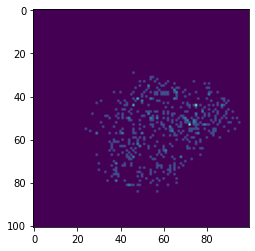

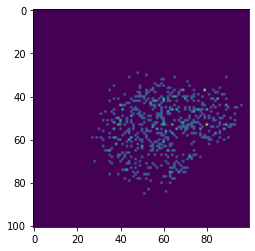

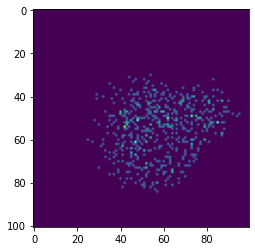

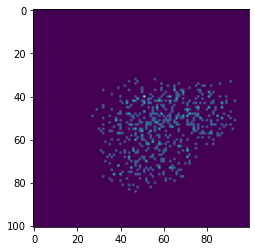

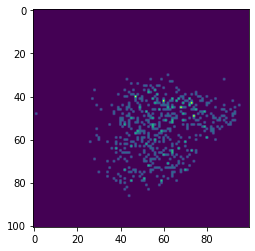

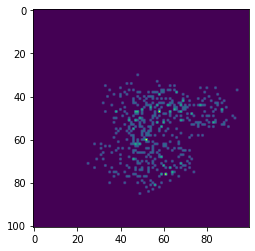

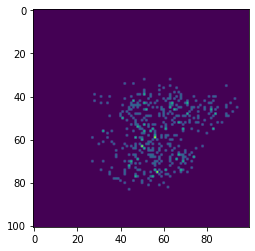

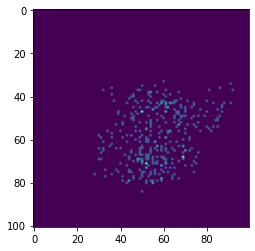

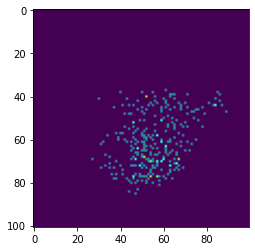

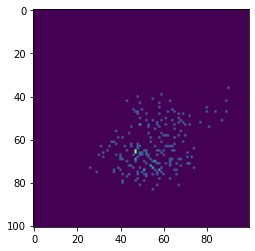

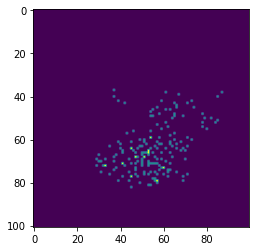

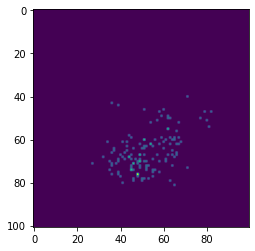

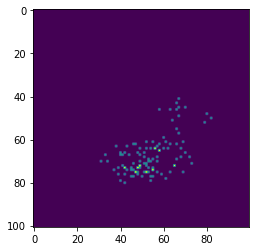

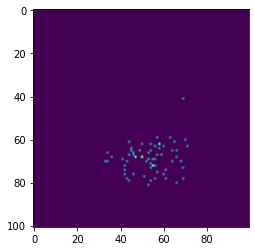

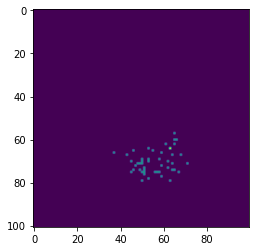

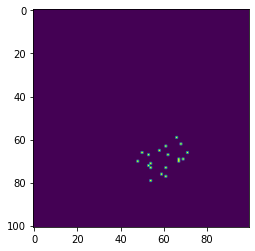

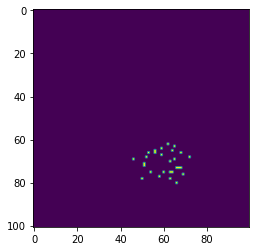

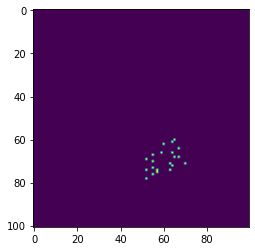

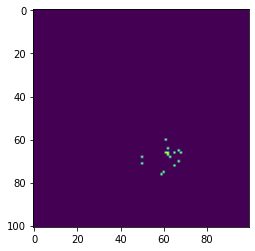

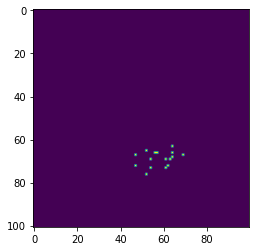

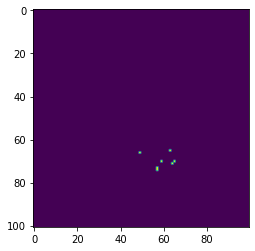

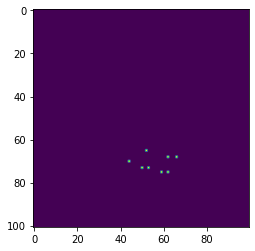

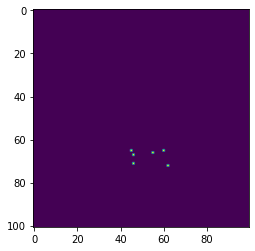

<Figure size 432x288 with 0 Axes>

In [161]:
for x in range(0,100):
    plt.imshow(D.density.grid[:,:,x])
    plt.show()
    plt.clf()

 <h1><center>Demystifying residues</h1></center>
<a id='demyst'></a>


In [ ]:
#subprocess.call(f"./darko_dists.sh {condition} {iteration} {cv_group} {resid1} {atomid1} {resid2} {atomid2}", shell = True)


In [98]:
resid1 = 153
resid2 = 325
condition = 'influx_apo_gate_CV'
iteration = 1
subprocess.call(f"./darko_dists.sh {condition} {iteration} {'demystifying'} {resid1} {'CA'} {resid2} {'CA'}", shell = True)


0

In [132]:
def get_demyst_dist_arr(condition, iteration1, iteration2):
    
    residue_pairs = [(186,414), (66,299), (153,325), (65,424), (33,186), (298,443), (202,291), (105,393),\
                    (108,190), (104,295), (109,427), (147, 454), (23,289), (74,190), (203,336), (144,346), \
                    (143, 391), (204,395), (92,455), (145,274), (186,430), (92,339), (123,294), (189,349), \
                    (156,299), (118,438), (94,396), (112,292), (61,186), (189,293)]
    
    start_dists = []
    final_dists = []
    
    for resid1, resid2 in residue_pairs:
        
        subprocess.call(f"./darko_dists.sh {condition} {iteration1} {'demystifying'} {resid1} {'CA'} {resid2} {'CA'}", shell = True)
        subprocess.call(f"./darko_dists.sh {condition} {iteration2} {'demystifying'} {resid1} {'CA'} {resid2} {'CA'}", shell = True)

        
        
        start = np.loadtxt(f'../textfiles_out/darko_dists_GMX/demystifying/{condition}.{iteration1}.{resid1}-{resid2}.xvg')[:,1]
        finish = np.loadtxt(f'../textfiles_out/darko_dists_GMX/demystifying/{condition}.{iteration2}.{resid1}-{resid2}.xvg')[:,1]
    
        start_dists.append(start)
        final_dists.append(finish)
    return residue_pairs, start_dists, final_dists

In [133]:
iteration1 = 1
iteration2 = 745
pairs, start, finish = get_demyst_dist_arr('influx_apo_gate_CV', iteration1, iteration2)

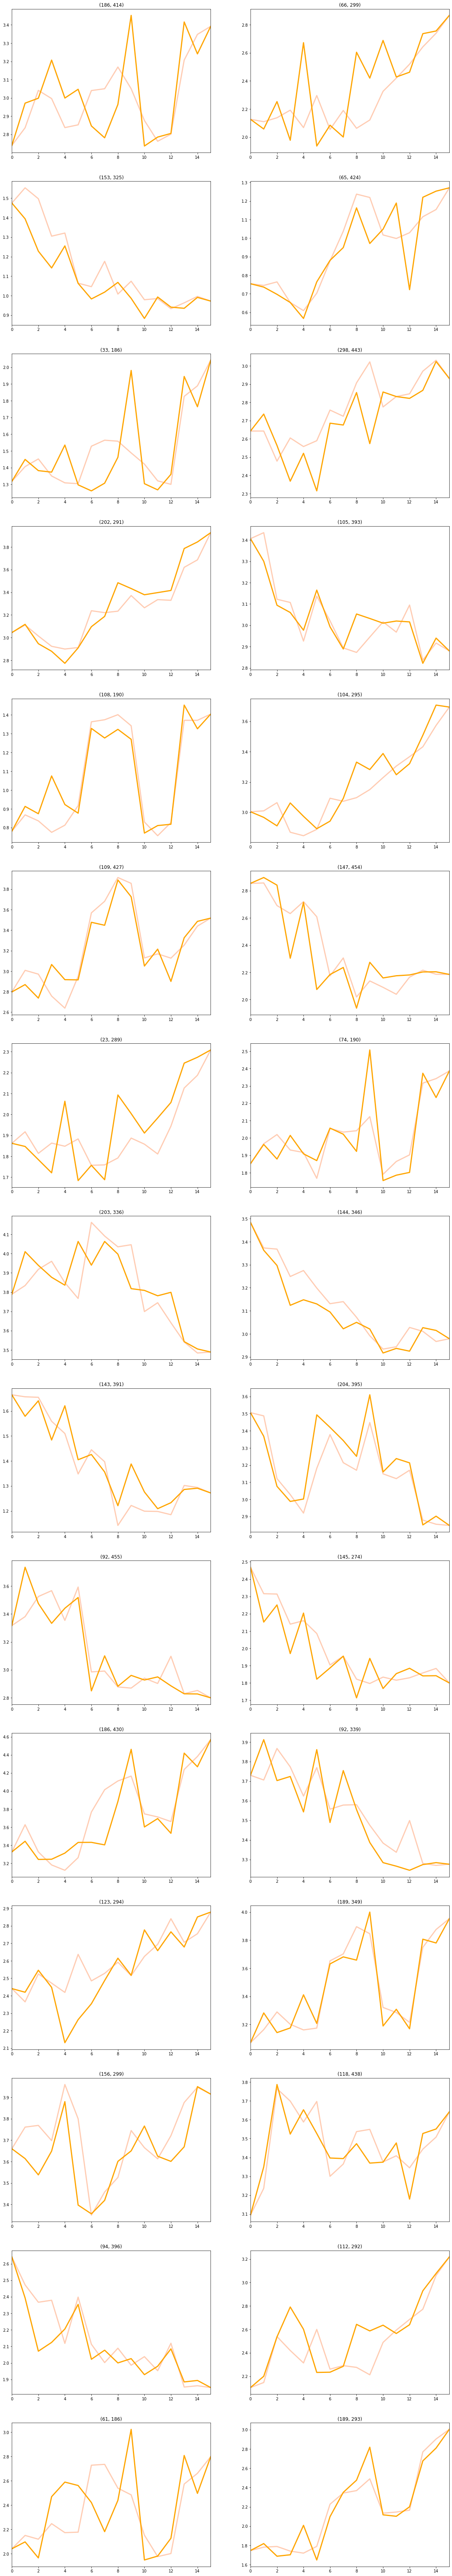

In [134]:
n_plots = len(pairs)
fig, ax = plt.subplots(ceil(n_plots / 2), 2, figsize=(20, 8 * ceil(n_plots / 2)))
ax = ax.flatten()

linewidth = 2
if n_plots % 2:
    fig.delaxes(ax[-1])   
    ax = ax[:-1]
    
    
for ax_loc in range(len(pairs)):
    ax[ax_loc].plot(np.flip(start[ax_loc]), color ='#FFCCB3', label =  f"{condition}-{iteration1}", linewidth = 3)
    ax[ax_loc].plot(np.flip(finish[ax_loc]), color = 'orange', label = f"{condition}-{iteration2}", linewidth = 3)
    ax[ax_loc].set_title(pairs[ax_loc])
    ax[ax_loc].set_xlim(0,15)
